# How to break a neural network


We're going to use neural networks to make correct predictions!

THEN WE'RE GOING TO BREAK THEM.

In [1]:
# a bajillion imports
import shutil
import requests
import tempfile
import os
caffe_root = '/opt/caffe/'
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.insert(0, caffe_root + 'python')

import caffe
plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [3]:
# Load the labels (so we know whether 242 means 'adorable puppy' or 'garbage can')
imagenet_labels_filename = caffe_root + '/data/ilsvrc12/synset_words.txt'
try:
    labels = np.loadtxt(imagenet_labels_filename, str, delimiter='\t')
except:
    !/opt/caffe/data/ilsvrc12/get_ilsvrc_aux.sh
    labels = np.loadtxt(imagenet_labels_filename, str, delimiter='\t')


Set Caffe to CPU mode because who even knows how to set up a GPU (not me)

In [75]:
caffe.set_mode_cpu()
# Load our model! trained by the GOOGLES! <3
def load_model():
    BATCH_SIZE = 1
    net = caffe.Net('/opt/caffe/models/bvlc_googlenet/deploy.prototxt',
                    '/models/bvlc_googlenet.caffemodel',
                    caffe.TEST)
    # change batch size to 1 for faster processing
    shape = list(net.blobs['data'].data.shape)
    shape[0] = BATCH_SIZE
    net.blobs['data'].reshape(*shape)
    net.blobs['prob'].reshape(BATCH_SIZE, )
    net.reshape() 
    return net
net = load_model()
# input preprocessing: 'data' is the name of the input blob == net.inputs[0]
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
transformer.set_transpose('data', (2,0,1))
#transformer.set_mean('data', np.load(caffe_root + 'python/caffe/imagenet/ilsvrc_2012_mean.npy').mean(1).mean(1)) # mean pixel
transformer.set_raw_scale('data', 255)  # the reference model operates on images in [0,255] range instead of [0,1]
transformer.set_channel_swap('data', (2,1,0))  # the reference model has channels in BGR order instead of RGB

If we're going to look at pictures of adorable dogs & pandas, we need a way to download them from the internet! This does that, and saves it to a png on our disk.

In [76]:
def get_png_image(url):
    fd, path = tempfile.mkstemp()
    tmpfile = os.fdopen(fd, "wb")
    response = requests.get(url, stream=True)
    shutil.copyfileobj(response.raw, tmpfile)
    !convert {path} {path}.png
    path = path + ".png"
    return transformer.preprocess('data', caffe.io.load_image(path))

Let's start with a simple classification.

Feed in the image (with some preprocessing) and classify with a forward pass.

In [77]:
cat_data = transformer.preprocess('data', caffe.io.load_image(caffe_root + 'examples/images/cat.jpg'))

In [92]:
print cat_data.shape

(3, 224, 224)


Great! The 3 means RGB, and the image is 224x224 pixels.

In [93]:
net.blobs['data'].data[...] = cat_data
out = net.forward()
pred_class = out['prob'][0].argmax()
print("Predicted class is #{}.".format(pred_class))

Predicted class is #282.


What did the input look like?

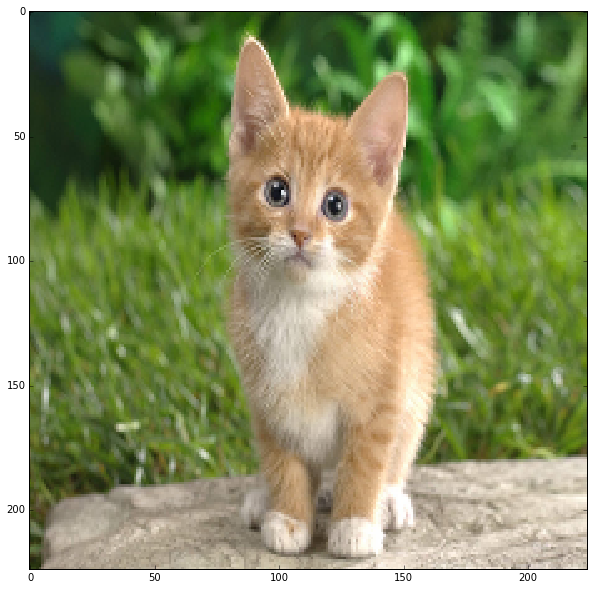

In [79]:
plt.imshow(transformer.deprocess('data', net.blobs['data'].data[0]))

Adorable, but was our classification correct?

In [80]:
print labels[pred_class]

n02123159 tiger cat


Let's put all that together into a function -- make a prediction & show the image

In [96]:
def predict(data, n_preds=6):
    net = load_model()
    net.blobs['data'].data[...] = data
    plt.imshow(transformer.deprocess('data', net.blobs['data'].data[0]))
    prob = net.forward()['prob']
    probs = prob[0]
    prediction = probs.argmax()
    top_k = probs.argsort()[::-1]
    for pred in top_k[:n_preds]:
        print "class: {cls}, label: {label}, certainty: {certainty}".format(
            cls=pred, label=labels[pred], certainty=probs[pred])
    return prob

In [ ]:
panda_url = 'https://upload.wikimedia.org/wikipedia/commons/c/cd/Panda_Cub_from_Wolong,_Sichuan,_China.JPG'
panda_data = get_png_image(panda_url)
probs = predict(panda_data, n_preds=1)


class: 412, label: n02747177 ashcan, trash can, garbage can, wastebin, ash bin, ash-bin, ashbin, dustbin, trash barrel, trash bin, certainty: 0.405762076378


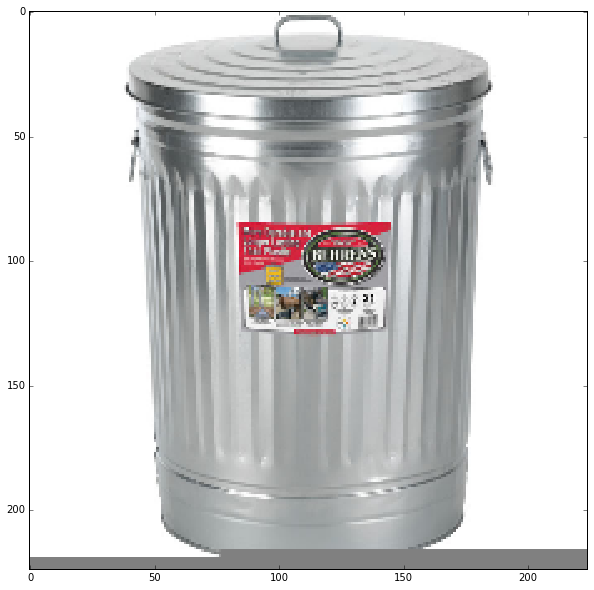

In [84]:
garbage_url = 'http://www.behrensmfg.com/wp-content/uploads/1270-31-gallon-trash-can.jpg'
garbage_data = get_png_image(garbage_url)
probs = predict(garbage_data, n_preds=1)

class: 623, label: n03658185 letter opener, paper knife, paperknife, certainty: 0.77632522583


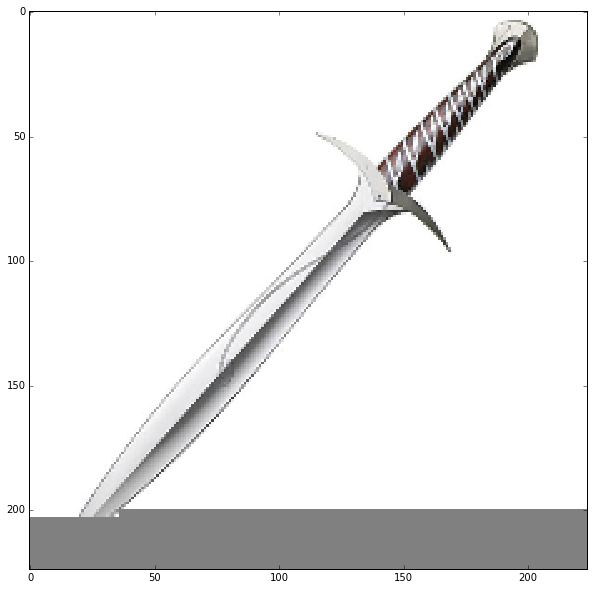

In [85]:
sword_url = 'http://a.tgcdn.net/images/products/zoom/f2bc_sting_the_sword_of_bilbo_baggins.jpg'
sword_data = get_png_image(sword_url)
probs = predict(sword_data, n_preds=1)

class: 285, label: n02124075 Egyptian cat, certainty: 0.3456556499


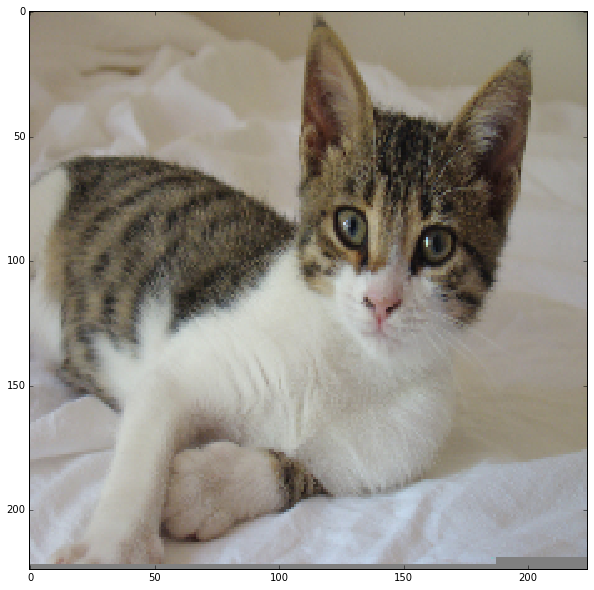

In [86]:
kitten_url = 'https://upload.wikimedia.org/wikipedia/commons/b/b9/CyprusShorthair.jpg'
kitten_data = get_png_image(kitten_url)
probs = predict(kitten_data, n_preds=1)

class: 263, label: n02113023 Pembroke, Pembroke Welsh corgi, certainty: 0.427658677101


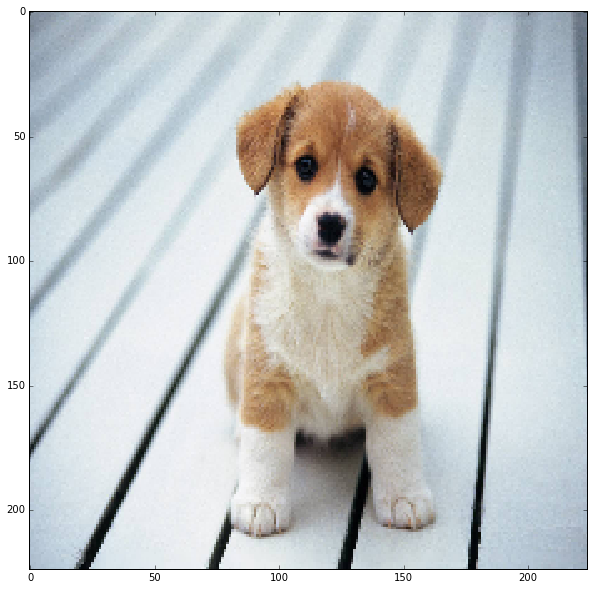

In [87]:
dog_url = 'http://cdn.playbuzz.com/cdn/7820ec56-cd7d-487c-87ba-30ca87219dc4/26084bf6-4235-4f8f-9c2f-b7294ea62c15.jpg'
dog_data = get_png_image(dog_url)
probs = predict(dog_data, n_preds=1)

class: 793, label: n04209133 shower cap, certainty: 0.997033953667


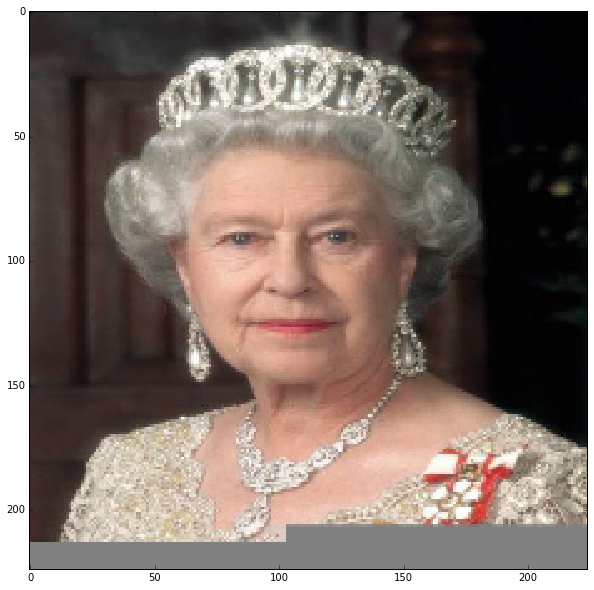

In [88]:
queen_url = 'http://www.librarising.com/astrology/celebs/images2/QR/queenelizabethii.jpg'
queen_data = get_png_image(queen_url)
probs = predict(queen_data, n_preds=1)

Predicted class is #716.
['n03930313 picket fence, paling'
 'n04604644 worm fence, snake fence, snake-rail fence, Virginia fence'
 'n03733281 maze, labyrinth' 'n04040759 radiator' 'n04532670 viaduct']


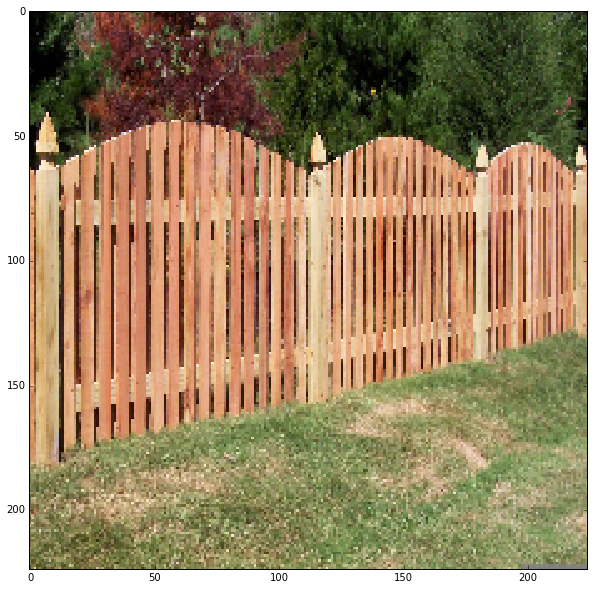

In [89]:
fence_url = 'http://jmarvinhandyman.com/wp-content/uploads/2014/04/fence-mossy-oak-wood-shadowbox_1373304.jpg'
classify(fence_url)
fence_data = np.copy(net.blobs['data'].data)

In [90]:
queen_data.shape

(3, 224, 224)

In [116]:
push_layer = 'prob'
push_idx = 777
print labels[push_idx]
push_dir = 1
diffs = net.blobs[push_layer].diff * 0
diffs[0][push_idx] = push_dir
backout = net.backward(prob=diffs)
grad = backout['data'].copy()

n04141327 scabbard


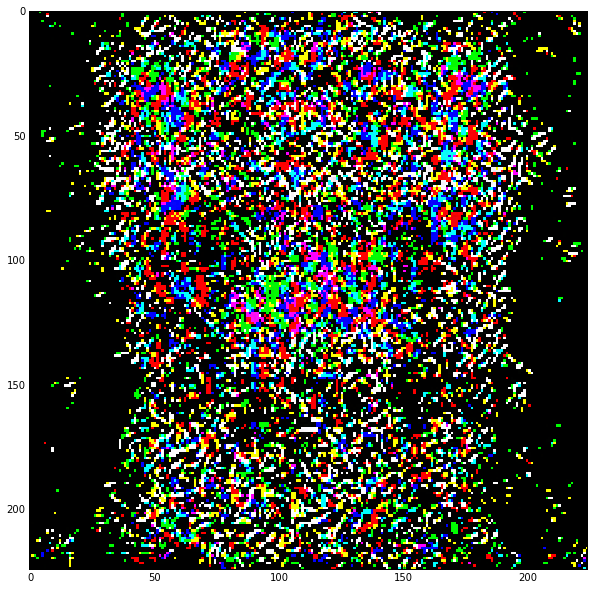

In [111]:
plt.imshow(transformer.deprocess('data', grad[0] *  1 / np.percentile(grad, 98)))


In [131]:
def compute_direction(probs):
    backout = net.backward(prob=probs)
    grad = backout['data'].copy()
    return np.sign(grad)

In [ ]:
np.ran

class: 549, label: n03291819 envelope, certainty: 0.117724090815
class: 911, label: n04599235 wool, woolen, woollen, certainty: 0.0626536905766
class: 419, label: n02786058 Band Aid, certainty: 0.0584063716233
class: 700, label: n03887697 paper towel, certainty: 0.046940125525
class: 551, label: n03314780 face powder, certainty: 0.027678437531
class: 549, label: n03291819 envelope, certainty: 0.117208428681
class: 911, label: n04599235 wool, woolen, woollen, certainty: 0.0630087405443
class: 419, label: n02786058 Band Aid, certainty: 0.0585272759199
class: 700, label: n03887697 paper towel, certainty: 0.0470158345997
class: 551, label: n03314780 face powder, certainty: 0.0274920202792
class: 549, label: n03291819 envelope, certainty: 0.114188604057
class: 911, label: n04599235 wool, woolen, woollen, certainty: 0.0638813897967
class: 419, label: n02786058 Band Aid, certainty: 0.0587441697717
class: 700, label: n03887697 paper towel, certainty: 0.0464437045157
class: 551, label: n0331478

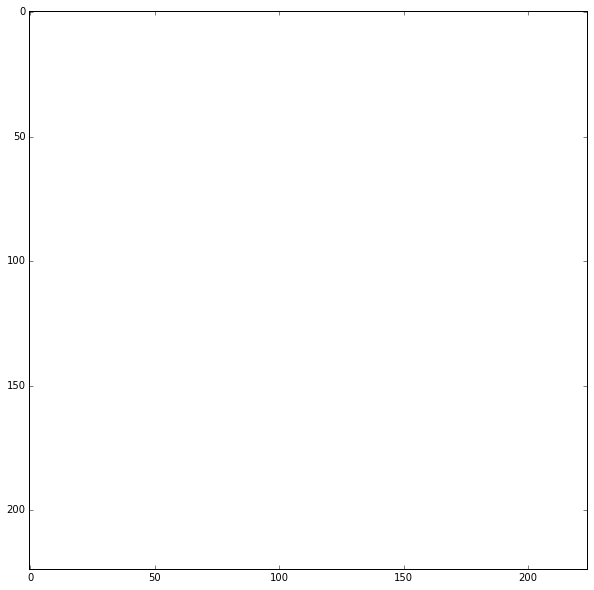

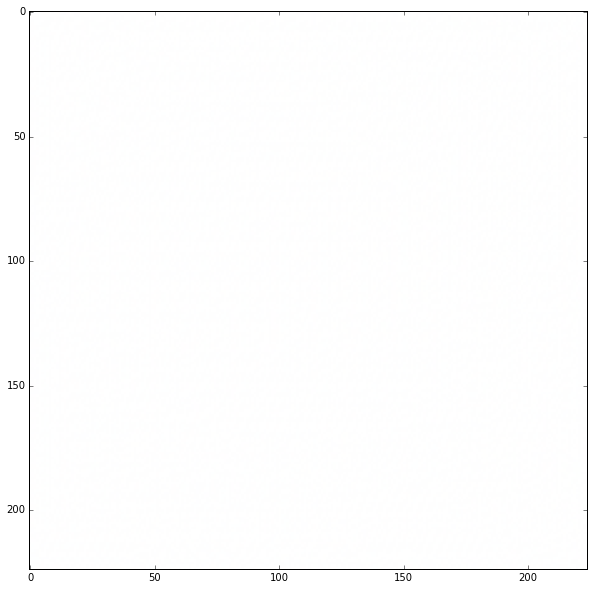

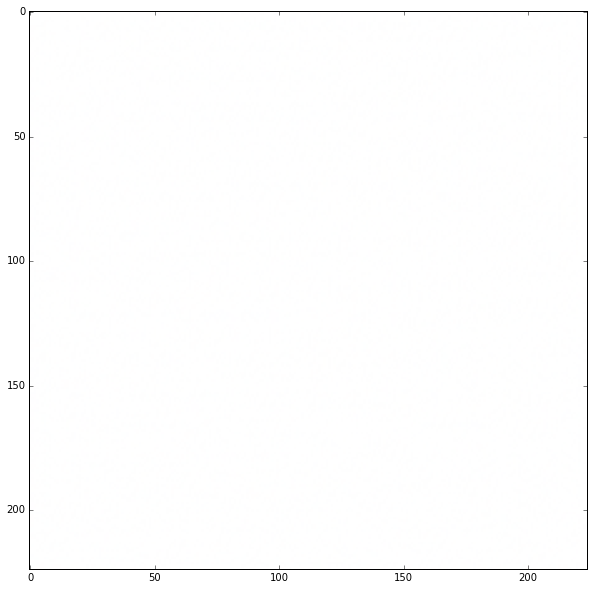

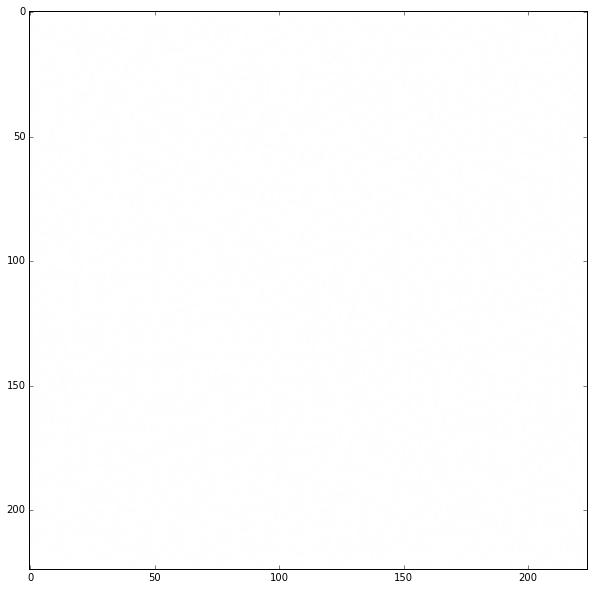

In [135]:
x = np.zeros_like(grad) * 255
for _ in range(4):
    probs = predict(x, n_preds=1)
    sign = compute_direction(probs)
    plt.figure()
    x = x - 0.2 * sign

class: 885, label: n04525038 velvet, certainty: 0.273825019598
class: 794, label: n04209239 shower curtain, certainty: 0.0640494972467
class: 911, label: n04599235 wool, woolen, woollen, certainty: 0.0619114302099
class: 700, label: n03887697 paper towel, certainty: 0.0466903671622
class: 904, label: n04589890 window screen, certainty: 0.0439454466105


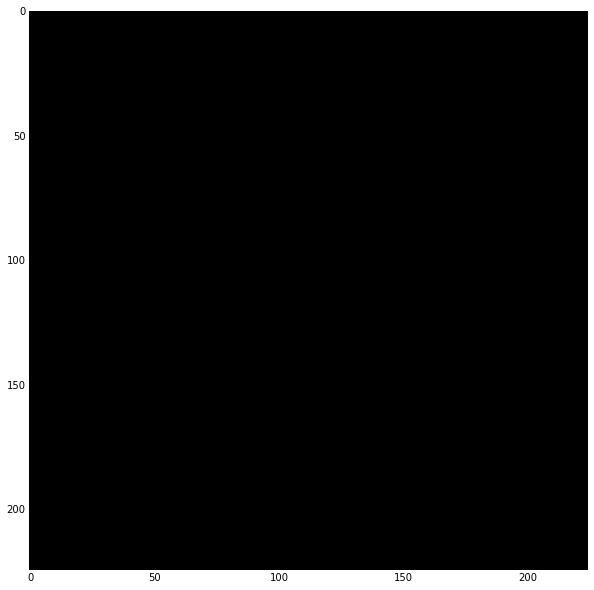

In [115]:
predict(np.zeros_like(gr))

In [ ]:
probs = predict(garbage_data)
plt.figure()
sign = compute_direction(probs)
predict(garbage_data - 0.99 * sign)
plt.imshow(transformer.deprocess('data', sign[0]))

Helper functions for visualization

In [69]:
# take an array of shape (n, height, width) or (n, height, width, channels)
# and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)
def vis_square(data, padsize=1, padval=0):
    data -= data.min()
    data /= data.max()
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = ((0, n ** 2 - data.shape[0]), (0, padsize), (0, padsize)) + ((0, 0),) * (data.ndim - 3)
    data = np.pad(data, padding, mode='constant', constant_values=(padval, padval))
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    
    plt.imshow(data)

The input image

The first layer filters, `conv1`

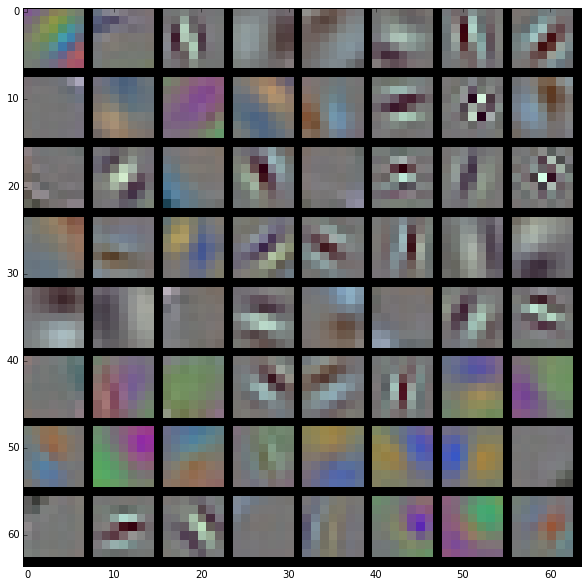

In [70]:
# the parameters are a list of [weights, biases]
filters = net.params['conv1/7x7_s2'][0].data
vis_square(filters.transpose(0, 2, 3, 1))

The first layer output, `conv1` (rectified responses of the filters above, first 36 only)

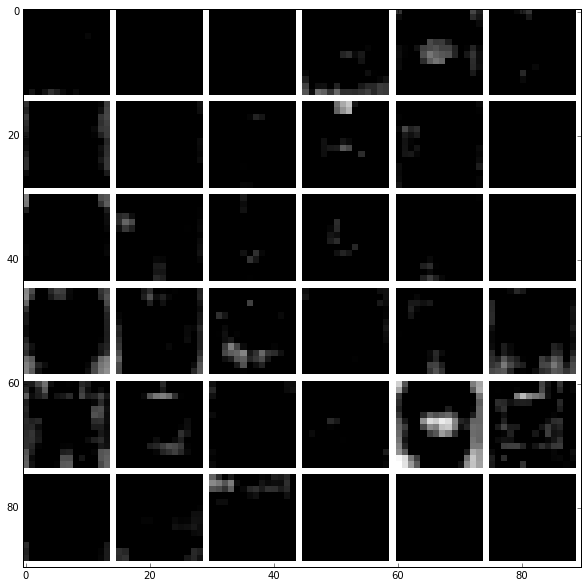

In [71]:
feat = net.blobs['inception_4a/pool_proj'].data[0, :36]
vis_square(feat, padval=1)

The second layer filters, `conv2`

There are 256 filters, each of which has dimension 5 x 5 x 48. We show only the first 48 filters, with each channel shown separately, so that each filter is a row.

In [74]:
filters = net.params['conv2'][0].data
vis_square(filters[:48].reshape(48**2, 5, 5))

KeyError: 'conv2'

The second layer output, `conv2` (rectified, only the first 36 of 256 channels)

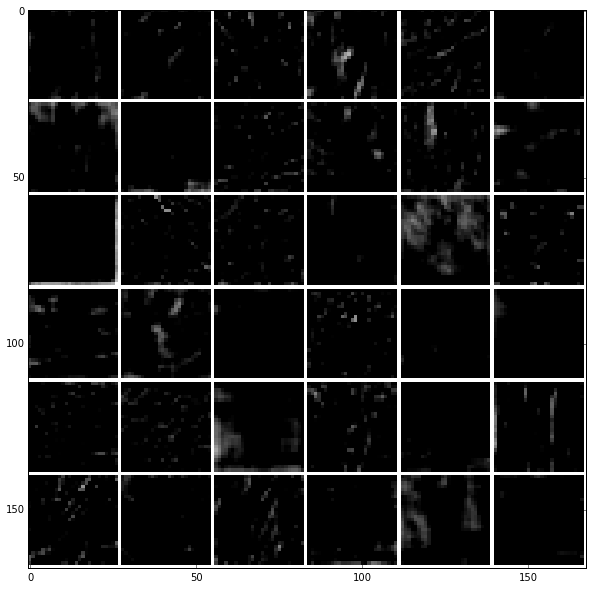

In [31]:
feat = net.blobs['conv2'].data[0, :36]
vis_square(feat, padval=1)

The third layer output, `conv3` (rectified, all 384 channels)

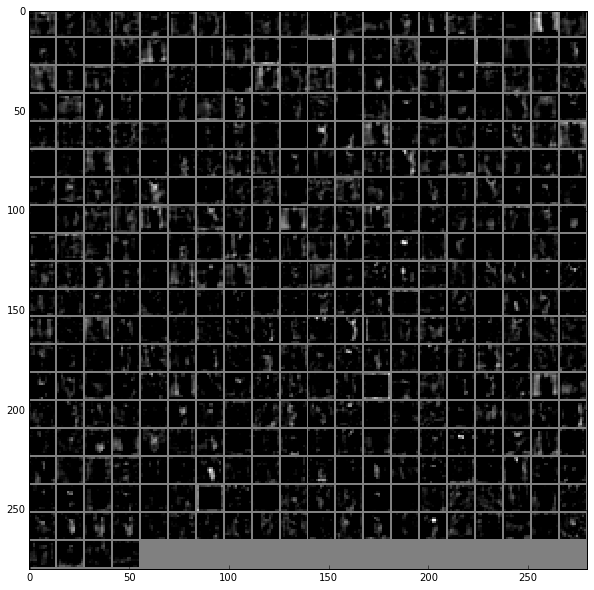

In [32]:
feat = net.blobs['conv3'].data[0]
vis_square(feat, padval=0.5)

The fourth layer output, `conv4` (rectified, all 384 channels)

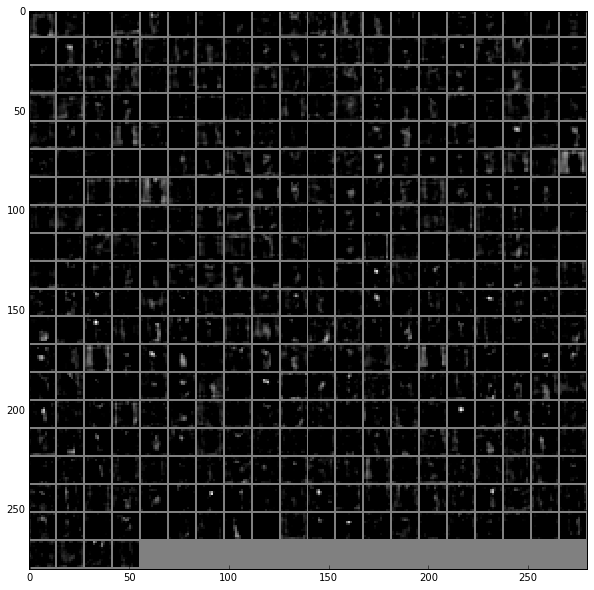

In [33]:
feat = net.blobs['conv4'].data[0]
vis_square(feat, padval=0.5)

The fifth layer output, `conv5` (rectified, all 256 channels)

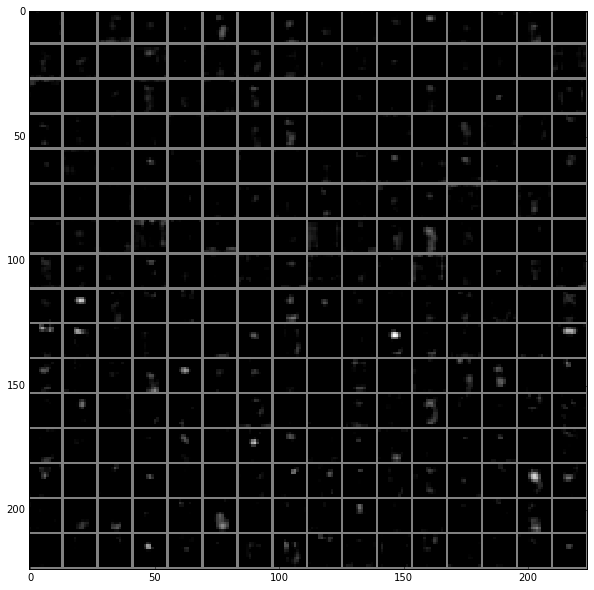

In [34]:
feat = net.blobs['conv5'].data[0]
vis_square(feat, padval=0.5)

The fifth layer after pooling, `pool5`

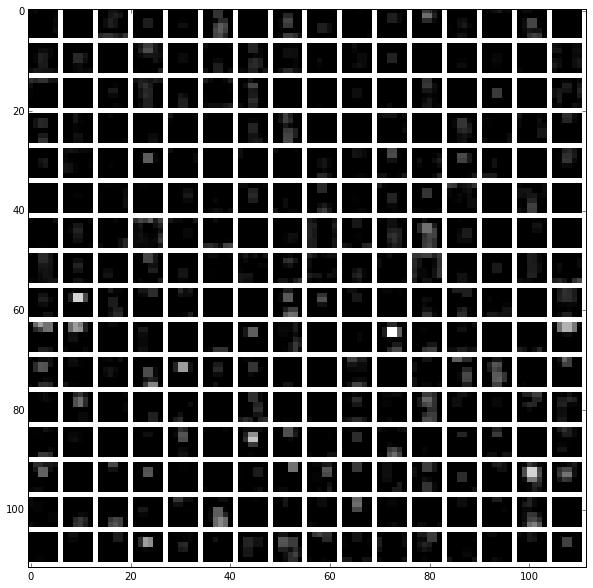

In [35]:
feat = net.blobs['pool5'].data[0]
vis_square(feat, padval=1)

The first fully connected layer, `fc6` (rectified)

We show the output values and the histogram of the positive values